In [ ]:
# Your existing imports
import numpy as np
import pandas as pd
import re
import matplotlib.pyplot as plt
from IPython.display import display
from sklearn.metrics import precision_recall_curve, roc_curve, auc
from sklearn.metrics import f1_score, precision_score, recall_score
from sklearn.metrics import roc_auc_score  # Add this import

# =============================================================================
# STEP 1: LOAD YOUR DATA
# =============================================================================

# Load your dataset
df = pd.read_csv('dataset/ed/finals/16_finalwithsigmoid.csv')

print("Dataset loaded successfully!")
print(f"Dataset shape: {df.shape}")
print(f"Columns: {list(df.columns)}")
print()

# =============================================================================
# STEP 2: DATA CLEANING
# =============================================================================

print("\n=== DATA PREPARATION FOR THRESHOLD ANALYSIS ===")
print("Filtering to rows with valid predictions (non-missing mortality_prob and label)...")
print(f"Before filtering: {len(df):,} rows")

# Keep only rows with predictions & labels
df_clean = df.dropna(subset=['mortality_prob', 'died_within_30_days']).copy()

# Coerce types & clip probabilities to valid range [0,1]
df_clean['mortality_prob'] = pd.to_numeric(df_clean['mortality_prob'], errors='coerce').clip(0, 1)
df_clean['died_within_30_days'] = pd.to_numeric(df_clean['died_within_30_days'], errors='coerce').astype(int)

# Drop any rows that may have turned NaN after coercion
df_clean = df_clean.dropna(subset=['mortality_prob', 'died_within_30_days'])

# Also fix dtype for symptom column if it exists
if 'symptom' in df_clean.columns:
    df_clean['symptom'] = pd.to_numeric(df_clean['symptom'], errors='coerce').astype('Int64')

print(f"After filtering: {len(df_clean):,} rows with predictions")


In [1]:
# ===== Cell 1: imports & shared utilities (minimal & simple) =====
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.metrics import roc_curve, roc_auc_score, confusion_matrix, auc
from sklearn.linear_model import LogisticRegression
from sklearn.isotonic import IsotonicRegression

# Optional: nicer plot resolution
plt.rcParams["figure.dpi"] = 120

# Small constant to avoid 0/1 edge cases when taking logit
EPS = 1e-6

def _ensure_binary(y):
    """
    Make sure labels are 0/1 and return a numpy array.
    Why: prevents silent bugs if labels are strings/floats or have stray values.
    """
    arr = pd.to_numeric(y, errors="coerce").fillna(0).astype(int).values
    bad = set(np.unique(arr)) - {0, 1}
    if bad:
        raise ValueError(f"Labels must be 0/1; found {bad}.")
    return arr

def _safe_prob(p, eps=EPS):
    """
    Convert to float and clip probabilities to (eps, 1-eps).
    Why: keeps values valid and avoids exact 0/1 that break logit math.
    Note: after cleaning, you shouldn't have NaNs here.
    """
    return np.clip(pd.to_numeric(p, errors="coerce").values, eps, 1 - eps)

def _safe_logit(p, eps=EPS):
    """
    Probabilities -> logits with clipping: log(p/(1-p)).
    Why: avoids ±inf if any p is 0 or 1.
    """
    p = np.clip(np.asarray(p, dtype=float), eps, 1 - eps)
    return np.log(p / (1 - p))











In [2]:
# ===== Cell 2: cleaning (super-duper simple) =====
def clean_dataset_simple(df, prob_col="mortality_prob", y_col="died_within_30_days"):
    """
    Very simple cleaner:
      1) Show how many rows and how many miss the score/label
      2) Keep only rows that have BOTH
      3) Make sure the score is in [0,1] and the label is 0/1
      4) Print after-cleaning summary
    """
    print("=== CLEANING ===")
    print(f"Rows BEFORE: {len(df):,}")
    miss_prob = int(df[prob_col].isna().sum())
    miss_lbl  = int(df[y_col].isna().sum())
    print(f"Missing {prob_col}: {miss_prob:,}")
    print(f"Missing {y_col}: {miss_lbl:,}")

    # Keep rows that have both a score and a label
    out = df.loc[df[prob_col].notna() & df[y_col].notna()].copy()

    # Make types clean and safe
    out[prob_col] = pd.to_numeric(out[prob_col], errors="coerce").astype(float).clip(0, 1)
    out[y_col]    = pd.to_numeric(out[y_col], errors="coerce").astype(int)

    # Drop any row that became NaN during coercion (rare)
    out = out.dropna(subset=[prob_col, y_col])

    kept = len(out)
    print("\n=== AFTER CLEANING ===")
    print(f"Rows AFTER : {kept:,}  (kept {kept/len(df):.1%} of original)")
    if kept > 0:
        lbl_vals = sorted(pd.Series(out[y_col]).unique().tolist())
        print(f"Label values present: {lbl_vals}")
        print(f"Prevalence (mean of {y_col}): {out[y_col].mean():.4f}")
        print(f"{prob_col}: mean={out[prob_col].mean():.4f}, min={out[prob_col].min():.4f}, max={out[prob_col].max():.4f}")
        print("\nPreview (first 3 rows of score+label):")
        print(out[[prob_col, y_col]].head(3))
    return out


In [3]:
df = pd.read_csv('dataset/ed/finals/16_finalwithsigmoid.csv')
# Call _ensure_binary on the label column (must be 0/1)



assert "mortality_prob" in df.columns
assert "died_within_30_days" in df.columns

df_clean = clean_dataset_simple(df, prob_col="mortality_prob", y_col="died_within_30_days")

y = _ensure_binary(df["died_within_30_days"])

# Call _safe_prob on mortality_prob (clips to (1e-6, 1-1e-6) and coerces to float)
p = _safe_prob(df["mortality_prob"])

# Call _safe_logit on those probabilities (safe finite logits)
z = _safe_logit(p)

=== CLEANING ===
Rows BEFORE: 591,892
Missing mortality_prob: 358,997
Missing died_within_30_days: 0

=== AFTER CLEANING ===
Rows AFTER : 232,895  (kept 39.3% of original)
Label values present: [0, 1]
Prevalence (mean of died_within_30_days): 0.0222
mortality_prob: mean=0.0163, min=0.0000, max=0.9417

Preview (first 3 rows of score+label):
   mortality_prob  died_within_30_days
0        0.003980                    0
3        0.010333                    0
4        0.002620                    0


In [9]:


print("NaNs after cleaning:",
      df_clean[["mortality_prob","died_within_30_days"]].isna().sum().to_dict())


# >>> Use the CLEANED dataframe, not df <<<

# extra guards
assert df_clean["mortality_prob"].notna().all()
assert df_clean["died_within_30_days"].notna().all()

# build arrays from df_clean
y = _ensure_binary(df_clean["died_within_30_days"])
p = _safe_prob(df_clean["mortality_prob"])
z = _safe_logit(p)

# quick prints
print("y (first 10):", y[:10])
print("p (first 10):", np.round(p[:10], 6))
print("z=logit(p) (first 10):", np.round(z[:10], 3))

# checks (should all pass now)
assert set(np.unique(y)).issubset({0, 1}), "Labels must be 0/1"
assert np.isfinite(p).all(), "Probabilities contain NaN/inf"
assert (p > 0).all() and (p < 1).all(), "Probabilities should be strictly inside (0,1)"
assert np.isfinite(z).all(), "Logits contain NaN/inf"

print("✅ Helpers working on CLEANED data. Shapes:", y.shape, p.shape, z.shape)

# optional: show coverage before vs after cleaning
print(f"Coverage (original df):  {df['mortality_prob'].notna().mean():.3f}")
print(f"Coverage (cleaned set): {df_clean['mortality_prob'].notna().mean():.3f}")



NaNs after cleaning: {'mortality_prob': 0, 'died_within_30_days': 0}
y (first 10): [0 0 0 0 0 0 0 0 0 0]
p (first 10): [0.00398  0.010333 0.00262  0.00398  0.024288 0.00398  0.00028  0.000693
 0.000488 0.005441]
z=logit(p) (first 10): [-5.523 -4.562 -5.942 -5.523 -3.693 -5.523 -8.181 -7.274 -7.625 -5.208]
✅ Helpers working on CLEANED data. Shapes: (232895,) (232895,) (232895,)
Coverage (original df):  0.393
Coverage (cleaned set): 1.000


In [11]:
# ===== Cell 3: bias detection (threshold-free, simple) =====
def auc_by_group(df, group_col, prob_col="mortality_prob", y_col="died_within_30_days"):
    """
    Compute AUC per group (no threshold). Groups with AUC much lower than overall
    deserve deeper fairness checks. AUC is NaN if a group has only one class.
    """
    rows = []
    for g, sub in df.groupby(group_col):
        y = _ensure_binary(sub[y_col])
        p = _safe_prob(sub[prob_col])
        auc_val = np.nan if len(np.unique(y)) < 2 else roc_auc_score(y, p)
        rows.append({"group": str(g), "AUC": auc_val, "n": len(sub), "events": int(y.sum())})
    out = pd.DataFrame(rows).set_index("group").sort_values("n", ascending=False)
    return out

def flag_bias_by_auc(df, group_col, prob_col="mortality_prob", y_col="died_within_30_days",
                     min_n=200, auc_drop=0.05):
    """
    Flag groups whose AUC is >= auc_drop below the overall AUC and have n >= min_n.
    """
    y_all = _ensure_binary(df[y_col])
    p_all = _safe_prob(df[prob_col])
    overall_auc = np.nan if len(np.unique(y_all)) < 2 else roc_auc_score(y_all, p_all)

    per = auc_by_group(df, group_col, prob_col, y_col).copy()
    per["overall_auc"] = overall_auc
    per["AUC_gap"] = overall_auc - per["AUC"]
    per["flag"] = (per["n"] >= min_n) & (per["AUC_gap"] >= auc_drop)
    return per

def plot_roc_by_group(df, group_col, prob_col="mortality_prob", y_col="died_within_30_days", title=None):
    """
    Plot overall ROC and overlay per-group curves (only for groups with both classes).
    """
    y = _ensure_binary(df[y_col])
    p = _safe_prob(df[prob_col])
    fpr, tpr, _ = roc_curve(y, p)
    base_auc = auc(fpr, tpr)

    plt.figure()
    plt.plot(fpr, tpr, label=f"Overall AUC={base_auc:.3f}")
    plt.plot([0, 1], [0, 1], "--", label="No-skill")

    for g, sub in df.groupby(group_col):
        yy = _ensure_binary(sub[y_col])
        if len(np.unique(yy)) < 2:
            continue
        pp = _safe_prob(sub[prob_col])
        f, t, _ = roc_curve(yy, pp)
        plt.plot(f, t, label=f"{g} (AUC={roc_auc_score(yy, pp):.3f})")

    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title(title or f"ROC by {group_col}")
    plt.legend(loc="lower right")
    plt.show()


In [27]:
# AUC by gender and race
auc_gender = auc_by_group(df_clean, "gender")
auc_race   = auc_by_group(df_clean, "race_standard")


overall_auc = roc_auc_score(df_clean["died_within_30_days"].astype(int),
                            df_clean["mortality_prob"].astype(float))


print("overal AUC:",overall_auc) 

print("\nAUC by gender:\n", auc_gender.round(3))
print("\nAUC by race:\n", auc_race.round(3))

# Flag groups with notable AUC drop vs overall (e.g., >= 0.05 and n >= 200)
flags_gender = flag_bias_by_auc(df_clean, "gender", auc_drop=0.05, min_n=200)
flags_race   = flag_bias_by_auc(df_clean, "race_standard", auc_drop=0.05, min_n=200)

print("\nFlags (gender):\n", flags_gender[["AUC","overall_auc","AUC_gap","n","flag"]])
print("\nFlags (race):\n",   flags_race[["AUC","overall_auc","AUC_gap","n","flag"]])

# Optional: ROC curve overlays (can be slow with many groups; safe to skip)
# plot_roc_by_group(df_clean, "gender", title="ROC by gender")
# plot_roc_by_group(df_clean, "race_standard", title="ROC by race_standard")


overal AUC: 0.8353287789034226

AUC by gender:
          AUC       n  events
group                       
F      0.850  136433    2467
M      0.812   96462    2706

AUC by race:
                                     AUC       n  events
group                                                  
White                             0.814  131424    3590
Black                             0.832   53687     683
Hispanic/Latino                   0.837   21868     196
Other/Unknown/Not Reported        0.894   14542     440
Asian                             0.843   10453     245
American Indian/Alaska Native     0.787     546       4
Native Hawaiian/Pacific Islander  0.897     285      15
Multiple Races                      NaN      90       0

Flags (gender):
             AUC  overall_auc   AUC_gap       n   flag
group                                                
F      0.850214     0.835329 -0.014885  136433  False
M      0.811640     0.835329  0.023688   96462  False

Flags (race):
            

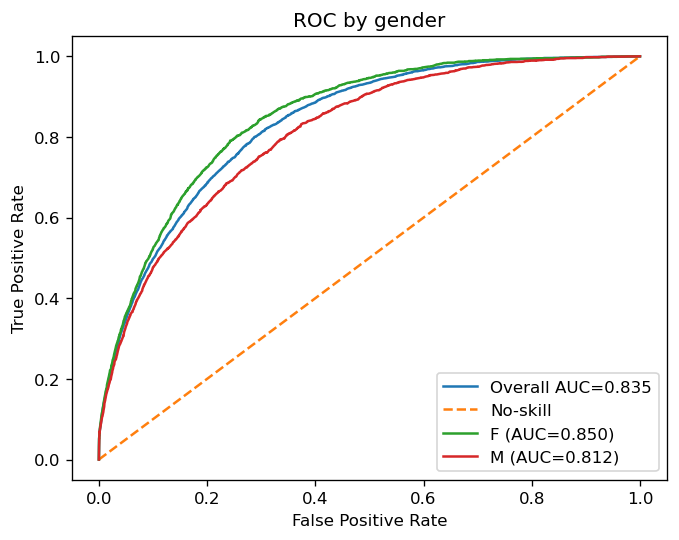

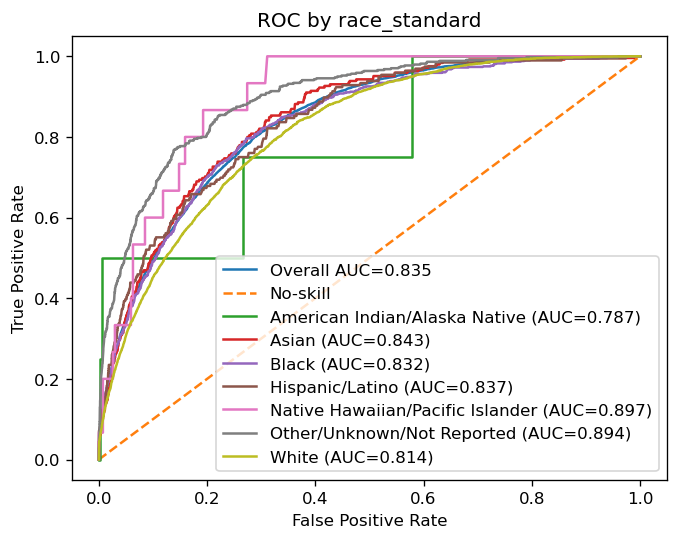

In [15]:
# ROC by gender (overlayed on overall)
plot_roc_by_group(df_clean, "gender", title="ROC by gender")

# ROC by race (skips groups that don't have both classes)
plot_roc_by_group(df_clean, "race_standard", title="ROC by race_standard")


In [17]:
from sklearn.metrics import roc_auc_score
overall_auc = roc_auc_score(df_clean["died_within_30_days"].astype(int),
                            df_clean["mortality_prob"].astype(float))
overall_auc

In [21]:
overall_auc

0.8353287789034226

In [19]:
auc_by_gender = df_clean.groupby("gender").apply(
    lambda g: roc_auc_score(g["died_within_30_days"].astype(int),
                            g["mortality_prob"].astype(float))
              if g["died_within_30_days"].nunique()==2 else np.nan
)


C:\Users\mitra\AppData\Local\Temp\ipykernel_44712\2828842139.py:1: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  auc_by_gender = df_clean.groupby("gender").apply(


In [23]:
auc_by_gender

gender
F    0.850214
M    0.811640
dtype: float64

In [29]:
# ===== Cell 3b: AUC with bootstrap CIs (simple) =====
def _bootstrap_auc(y, p, B=1000, seed=123):
    """
    Bootstrap AUC and 95% CI by resampling rows with replacement.
    Returns: auc_hat, ci_lo, ci_hi, draws (array)
    Skips if y has <2 classes (returns NaNs).
    """
    y = _ensure_binary(pd.Series(y))
    p = _safe_prob(pd.Series(p))
    if len(np.unique(y)) < 2:
        return np.nan, np.nan, np.nan, np.full(B, np.nan)

    rng = np.random.default_rng(seed)
    auc_draws = []
    n = len(y)
    for _ in range(B):
        idx = rng.integers(0, n, size=n)
        yy = y[idx]; pp = p[idx]
        if len(np.unique(yy)) < 2:
            auc_draws.append(np.nan)
        else:
            auc_draws.append(roc_auc_score(yy, pp))
    auc_draws = np.array(auc_draws, dtype=float)
    auc_hat = roc_auc_score(y, p)
    lo, hi = np.nanquantile(auc_draws, [0.025, 0.975])
    return float(auc_hat), float(lo), float(hi), auc_draws

def auc_by_group_with_ci(df, group_col, prob_col="mortality_prob", y_col="died_within_30_days",
                         B=1000, seed=123, min_pos=5, min_neg=5):
    """
    AUC per group with 95% bootstrap CI, plus the *gap to overall* and its CI
    (computed by bootstrapping overall and the group *independently* for simplicity).
    For tiny groups (positives<min_pos or negatives<min_neg), returns NaNs.
    """
    # overall
    y_all = _ensure_binary(df[y_col]); p_all = _safe_prob(df[prob_col])
    overall_auc, overall_lo, overall_hi, overall_draws = _bootstrap_auc(y_all, p_all, B=B, seed=seed)

    rows = []
    for g, sub in df.groupby(group_col):
        y = _ensure_binary(sub[y_col]); p = _safe_prob(sub[prob_col])
        n_pos = int(y.sum()); n_neg = int(len(y) - n_pos)
        if (n_pos < min_pos) or (n_neg < min_neg):
            rows.append({
                "group": str(g), "n": len(y), "events": n_pos,
                "AUC": np.nan, "AUC_lo": np.nan, "AUC_hi": np.nan,
                "AUC_gap": np.nan, "gap_lo": np.nan, "gap_hi": np.nan,
                "note": "too sparse"
            })
            continue

        auc_g, lo_g, hi_g, draws_g = _bootstrap_auc(y, p, B=B, seed=seed+7)

        # Gap CI (simple independent bootstrap of difference)
        # Note: independence is an approximation; good enough for screening
        m = min(len(overall_draws), len(draws_g))
        gap_draws = overall_draws[:m] - draws_g[:m]
        gap_lo, gap_hi = np.nanquantile(gap_draws, [0.025, 0.975])
        rows.append({
            "group": str(g), "n": len(y), "events": n_pos,
            "AUC": auc_g, "AUC_lo": lo_g, "AUC_hi": hi_g,
            "overall_auc": overall_auc,
            "AUC_gap": overall_auc - auc_g,
            "gap_lo": gap_lo, "gap_hi": gap_hi,
            "note": ""
        })

    out = pd.DataFrame(rows).set_index("group").sort_values("n", ascending=False)
    return out, {"overall_auc": overall_auc, "overall_lo": overall_lo, "overall_hi": overall_hi}


In [31]:
auc_gender_ci, overall_ci = auc_by_group_with_ci(df_clean, "gender", B=1000)
auc_race_ci,    _         = auc_by_group_with_ci(df_clean, "race_standard", B=1000)

print("Overall AUC (95% CI):", overall_ci)
print("\nGender AUC with CIs:\n", auc_gender_ci.round(3))
print("\nRace AUC with CIs:\n", auc_race_ci.round(3))


Overall AUC (95% CI): {'overall_auc': 0.8353287789034226, 'overall_lo': 0.8305379182775697, 'overall_hi': 0.8402022494850339}

Gender AUC with CIs:
             n  events    AUC  AUC_lo  AUC_hi  overall_auc  AUC_gap  gap_lo  \
group                                                                        
F      136433    2467  0.850   0.844   0.856        0.835   -0.015  -0.023   
M       96462    2706  0.812   0.804   0.819        0.835    0.024   0.014   

       gap_hi note  
group               
F      -0.006       
M       0.032       

Race AUC with CIs:
                                        n  events    AUC  AUC_lo  AUC_hi  \
group                                                                     
White                             131424    3590  0.814   0.807   0.820   
Black                              53687     683  0.832   0.818   0.846   
Hispanic/Latino                    21868     196  0.837   0.812   0.862   
Other/Unknown/Not Reported         14542     440  0.894   

In [33]:
# ===== Cell 3R: bias pre-checks (representation & outcome balance) =====

def _as_int_series(x):
    return pd.to_numeric(x, errors="coerce").fillna(0).astype(int)

def group_balance(df, group_col, y_col="died_within_30_days"):
    """
    Representation & outcome by a single group column.
    Shows each group's share of all rows, deaths, and its prevalence.
    Good to spot under/over-representation and outcome gaps.
    """
    y = _as_int_series(df[y_col])
    g = df[group_col].astype(str)

    counts = g.value_counts(dropna=False).rename("n")
    deaths = y.groupby(g).sum().rename("events")
    tab = pd.concat([counts, deaths], axis=1).fillna(0).astype(int)
    tab["prevalence"] = (tab["events"] / tab["n"]).replace([np.inf, -np.inf], np.nan)
    tab["share_rows"] = tab["n"] / len(df)
    tab["share_deaths"] = tab["events"] / y.sum() if y.sum() > 0 else 0.0
    return tab.sort_values("n", ascending=False)

def prevalence_by_group(df, group_col, y_col="died_within_30_days"):
    """
    Minimal prevalence table (n, events, prevalence) for a group column.
    Good when you just want rates without shares.
    """
    y = _as_int_series(df[y_col])
    g = df[group_col].astype(str)
    tab = df.groupby(g).agg(
        n=(y_col, "size"),
        events=(y_col, lambda s: _as_int_series(s).sum())
    )
    tab["prevalence"] = tab["events"] / tab["n"]
    return tab.sort_values("n", ascending=False)

def symptom_counts(df, symptom_col="symptom", k=20):
    """
    Top-K symptoms by row count (volume).
    Helps focus on clinically common contexts.
    """
    s = df[symptom_col].astype(str)
    tab = s.value_counts().rename("n").to_frame()
    return tab.head(k)

def symptom_deaths(df, symptom_col="symptom", y_col="died_within_30_days", k=20):
    """
    Top-K symptoms by number of deaths (event count).
    Highlights symptoms contributing the most deaths in absolute numbers.
    """
    y = _as_int_series(df[y_col])
    s = df[symptom_col].astype(str)
    deaths = y.groupby(s).sum().rename("events").to_frame()
    deaths["n"] = s.value_counts()
    deaths["prevalence"] = deaths["events"] / deaths["n"]
    return deaths.sort_values("events", ascending=False).head(k)

def symptom_case_fatality(df, symptom_col="symptom", y_col="died_within_30_days",
                          min_n=100, sort_by="cfr", k=20):
    """
    Symptoms ranked by case-fatality rate (prevalence) with a minimum n filter.
    Good to find 'deadliest' symptoms proportionally; min_n avoids tiny, unstable groups.
    sort_by: 'cfr' (highest rate) or 'n' (largest).
    """
    y = _as_int_series(df[y_col])
    s = df[symptom_col].astype(str)
    tab = df.groupby(s).agg(
        n=(y_col, "size"),
        events=(y_col, lambda t: _as_int_series(t).sum())
    )
    tab["cfr"] = tab["events"] / tab["n"]
    tab = tab[tab["n"] >= min_n].copy()
    tab = tab.sort_values("cfr" if sort_by=="cfr" else "n", ascending=False)
    return tab.head(k)

def symptom_by_group_cfr(df, group_col, symptom_col="symptom", y_col="died_within_30_days",
                         min_n=50):
    """
    Case-fatality by symptom within each group level (e.g., symptom×gender).
    Returns a tidy table: group, symptom, n, events, cfr. Filters small cells.
    Useful to compare, say, 'abd pain' male vs female.
    """
    y = _as_int_series(df[y_col])
    g = df[group_col].astype(str)
    s = df[symptom_col].astype(str)

    grp = df.copy()
    grp["_y"] = y
    grp["_g"] = g
    grp["_s"] = s

    tab = grp.groupby(["_g","_s"]).agg(
        n=("_y","size"),
        events=("_y","sum"),
    ).reset_index().rename(columns={"_g": group_col, "_s": symptom_col})
    tab = tab[tab["n"] >= min_n].copy()
    tab["cfr"] = tab["events"] / tab["n"]
    # For convenience, return both a long table and per-group top lists
    long = tab.sort_values(["cfr","n"], ascending=[False, False])
    top_per_group = long.groupby(group_col).head(20)
    return long, top_per_group

def symptom_by_intersection_cfr(df, group_cols=("symptom","gender","race_standard"),
                                y_col="died_within_30_days", min_n=50):
    """
    Case-fatality at intersections (e.g., symptom × gender × race_standard).
    Returns a table with n, events, cfr for each combination (filtered by min_n).
    This surfaces intersectional risk pockets, which are often where bias hides.
    """
    y = _as_int_series(df[y_col])
    data = df.copy()
    data["_y"] = y
    for c in group_cols:
        data[c] = data[c].astype(str)

    tab = data.groupby(list(group_cols)).agg(
        n=("_y","size"),
        events=("_y","sum")
    ).reset_index()
    tab = tab[tab["n"] >= min_n].copy()
    tab["cfr"] = tab["events"] / tab["n"]
    # sort high risk first, then by size
    tab = tab.sort_values(["cfr","n"], ascending=[False, False])
    return tab


In [35]:
# 1) Representation & outcome balance
print("By gender (balance):\n", group_balance(df_clean, "gender").round(3))
print("\nBy race_standard (balance):\n", group_balance(df_clean, "race_standard").round(3))

# 2) Top symptoms by volume / deaths / case-fatality
print("\nTop symptoms by volume:\n", symptom_counts(df_clean, "symptom", k=20).head(20))
print("\nTop symptoms by deaths (absolute):\n", symptom_deaths(df_clean, "symptom", k=20).head(20))
print("\nTop 'deadly' symptoms by case-fatality (min_n=100):\n",
      symptom_case_fatality(df_clean, "symptom", min_n=100, sort_by='cfr', k=20))

# 3) Symptom × gender case-fatality (filter tiny cells)
sym_gender_long, sym_gender_top = symptom_by_group_cfr(df_clean, group_col="gender",
                                                       symptom_col="symptom", min_n=50)
print("\nSymptom × gender (all cells ≥50):\n", sym_gender_long.head(10))
print("\nTop per gender by CFR:\n", sym_gender_top.groupby("gender").head(10))

# 4) Symptom × race_standard (similar call)
sym_race_long, sym_race_top = symptom_by_group_cfr(df_clean, group_col="race_standard",
                                                   symptom_col="symptom", min_n=50)
print("\nTop per race by CFR:\n", sym_race_top.groupby("race_standard").head(10))

# 5) Intersectional (symptom × gender × race_standard), cells ≥ 100
intersect = symptom_by_intersection_cfr(df_clean,
                                        group_cols=("symptom","gender","race_standard"),
                                        min_n=100)
print("\nTop intersections by CFR (n ≥ 100):\n", intersect.head(20))


By gender (balance):
              n  events  prevalence  share_rows  share_deaths
gender                                                      
F       136433    2467       0.018       0.586         0.477
M        96462    2706       0.028       0.414         0.523

By race_standard (balance):
                                        n  events  prevalence  share_rows  \
race_standard                                                              
White                             131424    3590       0.027       0.564   
Black                              53687     683       0.013       0.231   
Hispanic/Latino                    21868     196       0.009       0.094   
Other/Unknown/Not Reported         14542     440       0.030       0.062   
Asian                              10453     245       0.023       0.045   
American Indian/Alaska Native        546       4       0.007       0.002   
Native Hawaiian/Pacific Islander     285      15       0.053       0.001   
Multiple Races      

In [37]:
# ===== Cell 3V: visualization helpers (simple, matplotlib-only) =====
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# --- these expect you already ran Cell 3R functions like group_balance(), symptom_*(), etc. ---

def plot_group_balance(df, group_col, y_col="died_within_30_days", top=None, title=None):
    """
    Horizontal grouped bars: each group shows share of rows vs share of deaths,
    plus prints the prevalence table. Good to spot under/over-representation.
    """
    tab = group_balance(df, group_col, y_col).copy()
    if top is not None:
        tab = tab.head(top)
    idx = np.arange(len(tab))
    width = 0.4

    plt.figure()
    plt.barh(idx - width/2, tab["share_rows"].values, height=width, label="Share of rows")
    plt.barh(idx + width/2, tab["share_deaths"].values, height=width, label="Share of deaths")

    plt.yticks(idx, tab.index.astype(str))
    plt.xlabel("Share (fraction)")
    plt.title(title or f"Representation & deaths by {group_col}")
    plt.legend(loc="best")
    plt.tight_layout()
    plt.show()

    print((tab[["n","events","prevalence","share_rows","share_deaths"]]).round(3))

def plot_top_symptoms_by_volume(df, symptom_col="symptom", k=20, title=None):
    """
    Bar chart (horizontal) of top-K symptoms by count.
    """
    tab = symptom_counts(df, symptom_col, k=k)
    plt.figure()
    plt.barh(tab.index.astype(str)[::-1], tab["n"].values[::-1])
    plt.xlabel("Count")
    plt.title(title or f"Top {k} symptoms by volume")
    plt.tight_layout()
    plt.show()
    print(tab)

def plot_top_symptoms_by_deaths(df, symptom_col="symptom", y_col="died_within_30_days", k=20, title=None):
    """
    Bar chart of top-K symptoms by number of deaths (events).
    """
    tab = symptom_deaths(df, symptom_col, y_col, k=k)
    tab = tab.sort_values("events", ascending=True)
    plt.figure()
    plt.barh(tab.index.astype(str), tab["events"].values)
    plt.xlabel("Deaths (events)")
    plt.title(title or f"Top {k} symptoms by deaths")
    plt.tight_layout()
    plt.show()
    print(tab.sort_values("events", ascending=False))

def plot_deadliest_symptoms_by_cfr(df, symptom_col="symptom", y_col="died_within_30_days",
                                   min_n=100, k=20, title=None):
    """
    Bar chart of 'deadliest' symptoms by case-fatality rate (prevalence), with min_n filter.
    """
    tab = symptom_case_fatality(df, symptom_col, y_col, min_n=min_n, sort_by="cfr", k=k)
    tab = tab.sort_values("cfr", ascending=True)
    plt.figure()
    plt.barh(tab.index.astype(str), tab["cfr"].values)
    plt.xlabel("Case-fatality rate")
    plt.title(title or f"Top {k} symptoms by CFR (n ≥ {min_n})")
    plt.tight_layout()
    plt.show()
    print(tab.sort_values("cfr", ascending=False))

def plot_cfr_for_symptom_by_group(df, symptom, group_col="gender",
                                  symptom_col="symptom", y_col="died_within_30_days",
                                  min_n=30, title=None):
    """
    For a single symptom, compare groups (e.g., genders or races) by CFR.
    Useful to ask: within 'chest pain', are outcomes different for F vs M, or by race?
    """
    sub = df[df[symptom_col].astype(str) == str(symptom)].copy()
    tab = prevalence_by_group(sub, group_col, y_col)
    tab = tab[tab["n"] >= min_n]
    tab = tab.sort_values("prevalence", ascending=True)

    plt.figure()
    plt.barh(tab.index.astype(str), tab["prevalence"].values)
    plt.xlabel("Case-fatality rate within symptom")
    plt.title(title or f"{symptom}: CFR by {group_col} (n ≥ {min_n})")
    plt.tight_layout()
    plt.show()
    print(tab.sort_values("prevalence", ascending=False))

def plot_intersection_heatmap(df, row_col="symptom", col_col="gender",
                              y_col="died_within_30_days", metric="cfr",
                              min_n=50, top_rows=20, title=None):
    """
    Heatmap (imshow) of intersections, e.g., symptom × gender (or × race_standard).
    metric='cfr' uses events/n; metric='events' uses raw event counts.
    Rows are top 'row_col' by n to keep it readable; cells with n < min_n are NaN.
    """
    # build intersection table
    y = pd.to_numeric(df[y_col], errors="coerce").fillna(0).astype(int)
    tmp = df.copy()
    tmp["_y"] = y
    tmp[row_col] = tmp[row_col].astype(str)
    tmp[col_col] = tmp[col_col].astype(str)

    cell = tmp.groupby([row_col, col_col]).agg(n=("_y","size"), events=("_y","sum")).reset_index()
    # pick top rows by total n
    top = (cell.groupby(row_col)["n"].sum().sort_values(ascending=False).head(top_rows).index)
    cell = cell[cell[row_col].isin(top)]
    cell.loc[cell["n"] < min_n, ["events"]] = np.nan  # mask sparse cells

    if metric == "cfr":
        cell["value"] = cell["events"] / cell["n"]
    elif metric == "events":
        cell["value"] = cell["events"]
    else:
        raise ValueError("metric must be 'cfr' or 'events'")

    pivot = cell.pivot(index=row_col, columns=col_col, values="value")
    plt.figure()
    im = plt.imshow(pivot.values, aspect="auto")
    plt.colorbar(im, fraction=0.046, pad=0.04)
    plt.yticks(range(len(pivot.index)), pivot.index.astype(str))
    plt.xticks(range(len(pivot.columns)), pivot.columns.astype(str), rotation=45, ha="right")
    plt.title(title or f"{row_col} × {col_col} ({metric}; n per cell ≥ {min_n})")
    plt.tight_layout()
    plt.show()
    # print the numeric table for reference
    print(pivot.round(3))

def plot_auc_by_group_bar(auc_table, title=None):
    """
    Bar chart of AUC per group (pass the output of auc_by_group or simple_auc_by_group).
    """
    tab = auc_table.copy()
    tab = tab.sort_values("AUC", ascending=True)
    plt.figure()
    plt.barh(tab.index.astype(str), tab["AUC"].values)
    plt.xlabel("AUC")
    plt.title(title or "AUC by group")
    plt.tight_layout()
    plt.show()
    print(tab)

def plot_auc_with_ci_bar(auc_ci_table, title=None):
    """
    Bar chart with 95% CI from auc_by_group_with_ci() output.
    """
    tab = auc_ci_table[["AUC","AUC_lo","AUC_hi","n","events"]].dropna().copy()
    tab = tab.sort_values("AUC", ascending=True)
    y = np.arange(len(tab))
    plt.figure()
    plt.barh(y, tab["AUC"].values, xerr=[tab["AUC"]-tab["AUC_lo"], tab["AUC_hi"]-tab["AUC"]],
             align="center")
    plt.yticks(y, tab.index.astype(str))
    plt.xlabel("AUC (with 95% CI)")
    plt.title(title or "AUC by group (with CI)")
    plt.tight_layout()
    plt.show()
    print(tab.round(3))


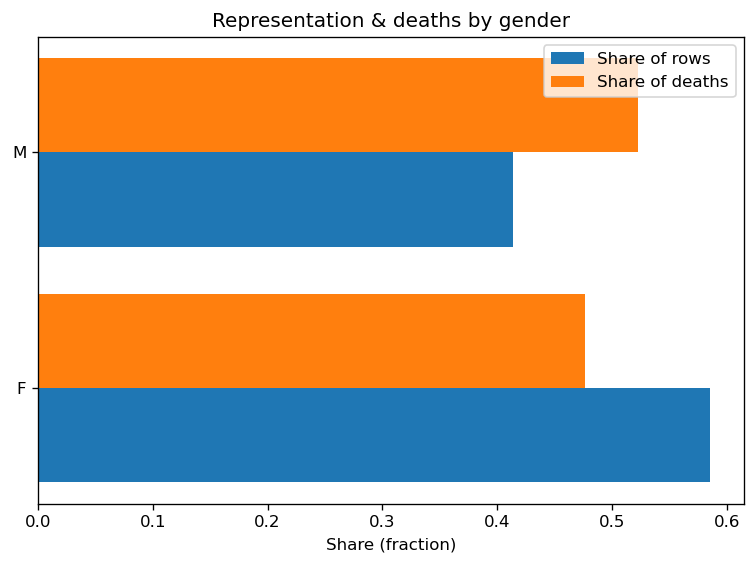

             n  events  prevalence  share_rows  share_deaths
gender                                                      
F       136433    2467       0.018       0.586         0.477
M        96462    2706       0.028       0.414         0.523


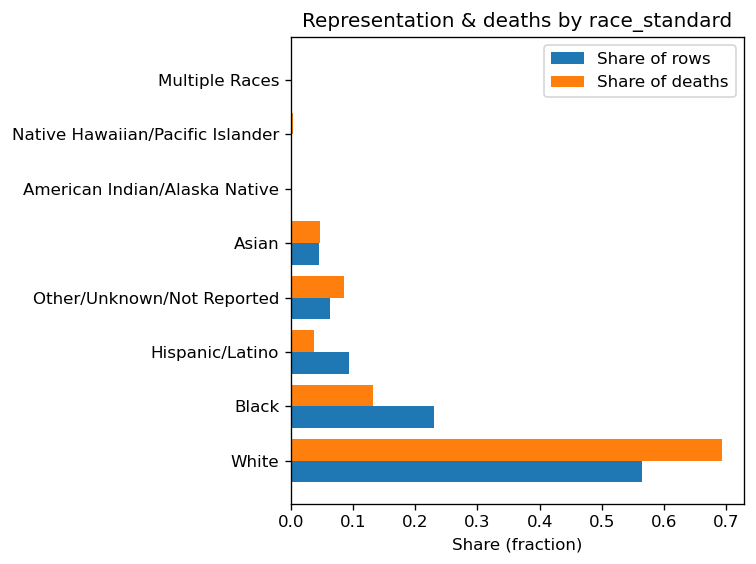

                                       n  events  prevalence  share_rows  \
race_standard                                                              
White                             131424    3590       0.027       0.564   
Black                              53687     683       0.013       0.231   
Hispanic/Latino                    21868     196       0.009       0.094   
Other/Unknown/Not Reported         14542     440       0.030       0.062   
Asian                              10453     245       0.023       0.045   
American Indian/Alaska Native        546       4       0.007       0.002   
Native Hawaiian/Pacific Islander     285      15       0.053       0.001   
Multiple Races                        90       0       0.000       0.000   

                                  share_deaths  
race_standard                                   
White                                    0.694  
Black                                    0.132  
Hispanic/Latino                          0.

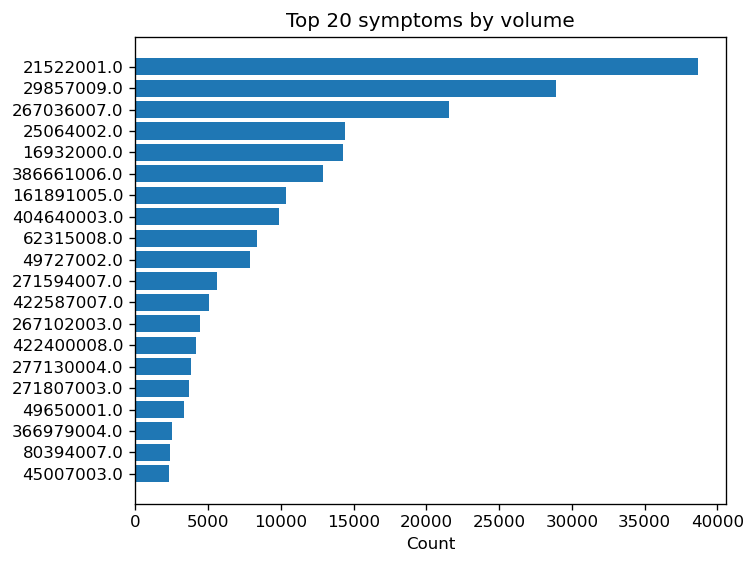

                 n
symptom           
21522001.0   38663
29857009.0   28940
267036007.0  21527
25064002.0   14440
16932000.0   14246
386661006.0  12918
161891005.0  10342
404640003.0   9889
62315008.0    8380
49727002.0    7877
271594007.0   5619
422587007.0   5052
267102003.0   4465
422400008.0   4205
277130004.0   3867
271807003.0   3671
49650001.0    3345
366979004.0   2506
80394007.0    2382
45007003.0    2335


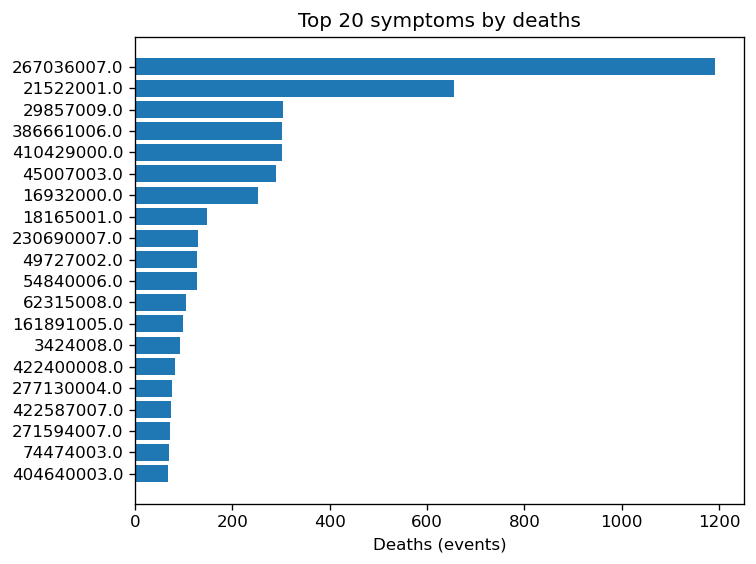

             events      n  prevalence
symptom                               
267036007.0    1192  21527    0.055372
21522001.0      655  38663    0.016941
29857009.0      304  28940    0.010504
386661006.0     302  12918    0.023378
410429000.0     302    430    0.702326
45007003.0      290   2335    0.124197
16932000.0      252  14246    0.017689
18165001.0      147    905    0.162431
230690007.0     129    785    0.164331
49727002.0      127   7877    0.016123
54840006.0      127    797    0.159348
62315008.0      105   8380    0.012530
161891005.0      99  10342    0.009573
3424008.0        93   2072    0.044884
422400008.0      82   4205    0.019501
277130004.0      75   3867    0.019395
422587007.0      74   5052    0.014648
271594007.0      71   5619    0.012636
74474003.0       69    689    0.100145
404640003.0      68   9889    0.006876


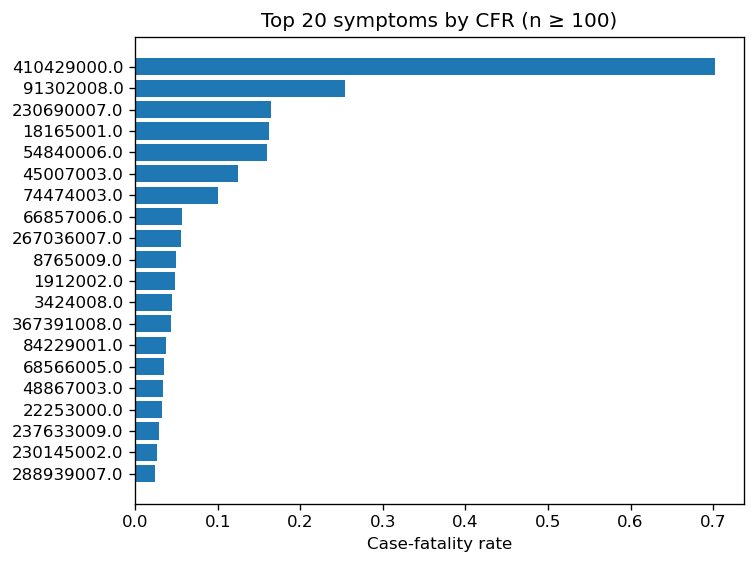

                 n  events       cfr
symptom                             
410429000.0    430     302  0.702326
91302008.0     134      34  0.253731
230690007.0    785     129  0.164331
18165001.0     905     147  0.162431
54840006.0     797     127  0.159348
45007003.0    2335     290  0.124197
74474003.0     689      69  0.100145
66857006.0     781      44  0.056338
267036007.0  21527    1192  0.055372
8765009.0      818      40  0.048900
1912002.0      545      26  0.047706
3424008.0     2072      93  0.044884
367391008.0    276      12  0.043478
84229001.0    1246      46  0.036918
68566005.0     407      14  0.034398
48867003.0     829      28  0.033776
22253000.0     547      18  0.032907
237633009.0   1036      30  0.028958
230145002.0    267       7  0.026217
288939007.0    537      13  0.024209


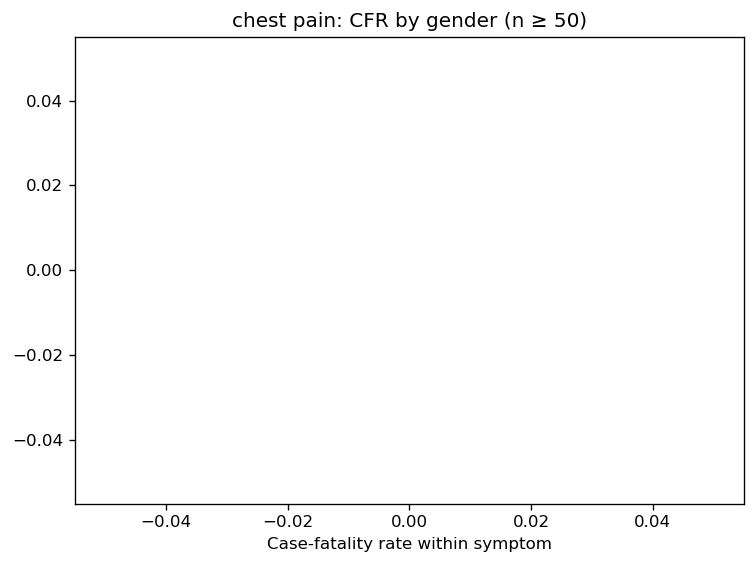

Empty DataFrame
Columns: [n, events, prevalence]
Index: []


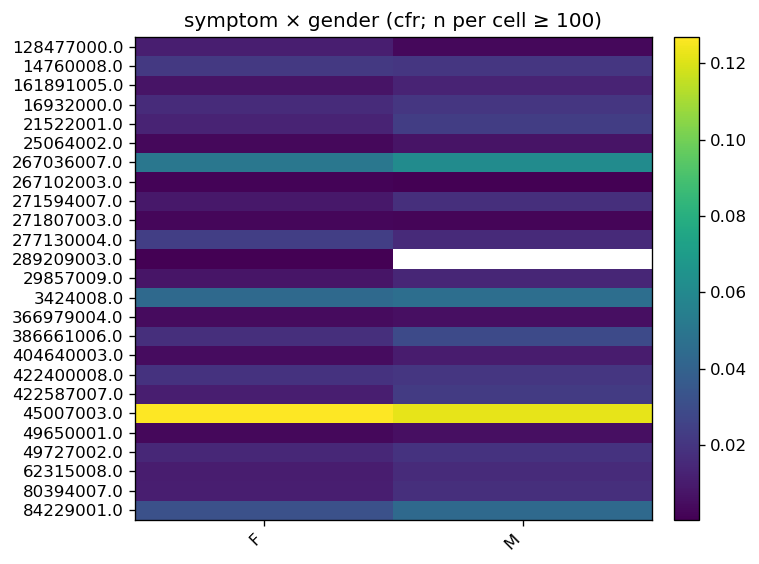

gender           F      M
symptom                  
128477000.0  0.011  0.003
14760008.0   0.021  0.020
161891005.0  0.007  0.013
16932000.0   0.016  0.020
21522001.0   0.013  0.023
25064002.0   0.003  0.007
267036007.0  0.050  0.061
267102003.0  0.001  0.001
271594007.0  0.009  0.018
271807003.0  0.003  0.002
277130004.0  0.024  0.015
289209003.0  0.000    NaN
29857009.0   0.007  0.014
3424008.0    0.044  0.046
366979004.0  0.004  0.006
386661006.0  0.018  0.029
404640003.0  0.005  0.010
422400008.0  0.019  0.020
422587007.0  0.011  0.022
45007003.0   0.127  0.122
49650001.0   0.003  0.006
49727002.0   0.014  0.019
62315008.0   0.011  0.016
80394007.0   0.011  0.018
84229001.0   0.032  0.044


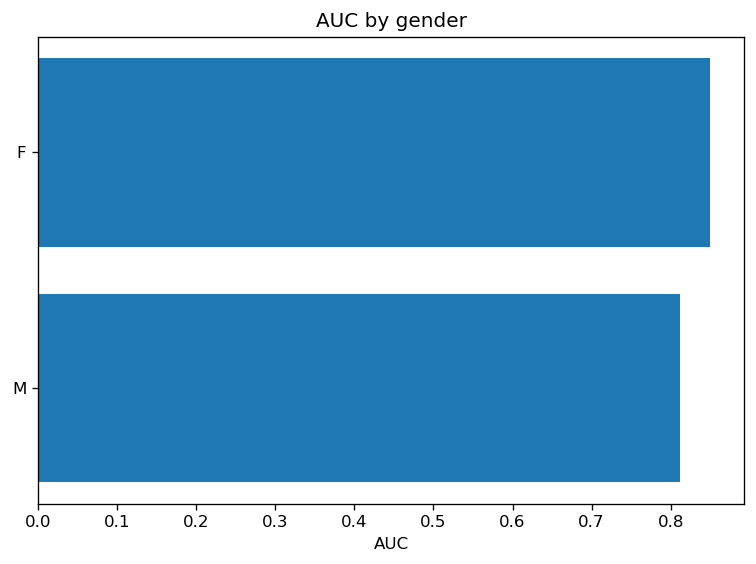

            AUC       n  events
group                          
M      0.811640   96462    2706
F      0.850214  136433    2467


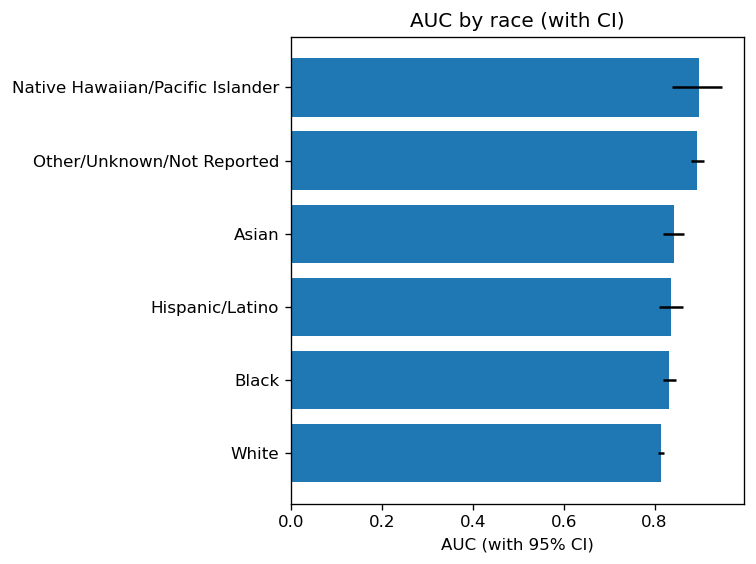

                                    AUC  AUC_lo  AUC_hi       n  events
group                                                                  
White                             0.814   0.808   0.820  131424    3590
Black                             0.832   0.818   0.847   53687     683
Hispanic/Latino                   0.837   0.810   0.863   21868     196
Asian                             0.843   0.820   0.865   10453     245
Other/Unknown/Not Reported        0.894   0.880   0.909   14542     440
Native Hawaiian/Pacific Islander  0.897   0.838   0.949     285      15


In [43]:
# Representation & deaths (gender / race)
plot_group_balance(df_clean, "gender")
plot_group_balance(df_clean, "race_standard")

# Symptoms
plot_top_symptoms_by_volume(df_clean, k=20)
plot_top_symptoms_by_deaths(df_clean, k=20)
plot_deadliest_symptoms_by_cfr(df_clean, min_n=100, k=20)

# Within a symptom, compare groups (e.g., gender) by CFR
plot_cfr_for_symptom_by_group(df_clean, symptom="chest pain", group_col="gender", min_n=50)

# Intersections: symptom × gender heatmap of CFR (or use col_col="race_standard")
plot_intersection_heatmap(df_clean, row_col="symptom", col_col="gender", metric="cfr", min_n=100, top_rows=25)
# plot_intersection_heatmap(df_clean, row_col="symptom", col_col="race_standard", metric="cfr", min_n=100, top_rows=25)


# AUC bars
auc_gender = auc_by_group(df_clean, "gender")
plot_auc_by_group_bar(auc_gender, title="AUC by gender")
auc_race_ci, _ = auc_by_group_with_ci(df_clean, "race_standard", B=500)  # fewer draws for speed
plot_auc_with_ci_bar(auc_race_ci, title="AUC by race (with CI)")


In [ ]:
# ============================
# CALIBRATION CHECKER (MEASUREMENT ONLY, WITH "WHY IT'S GOOD" NOTES)
# ============================
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from typing import Dict, Tuple, Optional
from sklearn.linear_model import LogisticRegression

# ---------- Utility ----------
def _safe_logit(p: np.ndarray, eps: float = 1e-6) -> np.ndarray:
    """
    Convert probabilities p in (0,1) to logits log(p/(1-p)).
    Clipping avoids infinities when p is 0 or 1.
    Why it’s good: using logits makes linear calibration modeling stable and numerically well-behaved.
    """
    p = np.clip(np.asarray(p, dtype=float), eps, 1 - eps)
    return np.log(p / (1 - p))

# ---------- Core calibration metrics ----------
def calibration_slope_intercept(y: np.ndarray, p: np.ndarray) -> Tuple[float, float]:
    """
    Estimate calibration-in-the-large (intercept) and calibration slope (slope) by fitting:
      logit(E[Y]) = a + b * logit(p).
    Ideal: intercept a ≈ 0, slope b ≈ 1. Returns (a, b); (nan, nan) if y has one class.
    Why it’s good: data-efficient summary used widely in clinical prediction; quickly tells if risks are globally shifted (a) or over/under-confident (b).
    """
    y = np.asarray(y, dtype=int)
    if len(np.unique(y)) < 2:
        return float("nan"), float("nan")
    z = _safe_logit(p).reshape(-1, 1)
    lr = LogisticRegression(solver="lbfgs", max_iter=1000)
    lr.fit(z, y)
    a = float(lr.intercept_[0])
    b = float(lr.coef_[0][0])
    return a, b

def ece_mce(y: np.ndarray, p: np.ndarray, n_bins: int = 15) -> Tuple[float, float]:
    """
    Expected Calibration Error (ECE) and Maximum Calibration Error (MCE) via uniform-probability bins.
    - ECE: weighted average |observed - predicted| per bin.
    - MCE: largest absolute gap across bins. Smaller is better.
    Why it’s good: ECE/MCE give intuitive, threshold-free calibration gaps that are easy to explain and visualize.
    """
    y = np.asarray(y, dtype=int)
    p = np.clip(np.asarray(p, dtype=float), 0, 1)
    bins = np.linspace(0.0, 1.0, n_bins + 1)
    idx = np.digitize(p, bins) - 1
    ece = 0.0
    mce = 0.0
    N = len(y)
    for b in range(n_bins):
        m = idx == b
        if not np.any(m):
            continue
        acc = y[m].mean()      # observed rate in the bin
        conf = p[m].mean()     # average predicted in the bin
        gap = abs(acc - conf)
        ece += gap * (m.sum() / N)
        mce = max(mce, gap)
    return float(ece), float(mce)

def brier(y: np.ndarray, p: np.ndarray) -> float:
    """
    Brier score = mean squared error between probability predictions and outcomes.
    Range [0,1], smaller is better.
    Why it’s good: a strictly proper scoring rule that rewards well-calibrated, sharp probabilities in one number.
    """
    y = np.asarray(y, dtype=float)
    p = np.clip(np.asarray(p, dtype=float), 0, 1)
    return float(np.mean((p - y) ** 2))

def log_loss_nll(y: np.ndarray, p: np.ndarray, eps: float = 1e-12) -> float:
    """
    Negative log-likelihood (log loss) of probabilistic predictions.
    Penalizes confident wrong predictions more. Smaller is better.
    Why it’s good: a gold-standard proper scoring rule aligned with maximum likelihood; sensitive to overconfidence.
    """
    y = np.asarray(y, dtype=float)
    p = np.clip(np.asarray(p, dtype=float), eps, 1 - eps)
    return float(-np.mean(y * np.log(p) + (1 - y) * np.log(1 - p)))

def mean_pred_vs_obs(y: np.ndarray, p: np.ndarray) -> Tuple[float, float, float]:
    """
    Compare average predicted risk to observed prevalence:
    - mean_pred      : E[p]  (expected event rate across patients)
    - observed_prev  : E[y]  (observed event rate / prevalence)
    - E_over_O ratio : mean_pred / observed_prev  (≈1 is ideal)
      >1 indicates global overestimation; <1 indicates underestimation.
    Why it’s good: a simple, clinician-friendly “sanity check” for calibration-in-the-large before deeper analysis.
    """
    p_mean = float(np.mean(p))
    obs = float(np.mean(y))
    e_over_o = (p_mean / obs) if obs > 0 else float("inf")
    return p_mean, obs, e_over_o

def hosmer_lemeshow(y: np.ndarray, p: np.ndarray, g: int = 10) -> Dict[str, float]:
    """
    Hosmer–Lemeshow goodness-of-fit test (grouped by predicted-risk deciles).
    Returns {'HL_X2': chi-square, 'df': degrees_of_freedom}. Interpret cautiously (sample-size sensitive).
    Why it’s good: a classic omnibus check that can flag severe miscalibration patterns; use alongside ECE and plots.
    """
    order = np.argsort(p)
    y_sorted = y[order]
    p_sorted = p[order]
    indices = np.array_split(np.arange(len(y)), g)
    chi2 = 0.0
    dof = g - 2
    for idx in indices:
        og = y_sorted[idx].sum()     # observed events in group
        eg = p_sorted[idx].sum()     # expected events in group
        ng = len(idx)
        var = eg * (1 - (eg / max(ng, 1)))  # simple variance approx on counts
        if var > 0:
            chi2 += (og - eg) ** 2 / var
    return {"HL_X2": float(chi2), "df": int(dof)}

# ---------- Plot (optional visualization) ----------
def plot_reliability(y: np.ndarray, p: np.ndarray, n_bins: int = 15, title: str = "Reliability diagram") -> None:
    """
    Reliability diagram: observed event rate vs mean predicted probability per bin.
    Perfect calibration lies on the diagonal (y = x).
    Why it’s good: fast visual diagnosis of under/overestimation and nonlinear calibration issues.
    """
    y = np.asarray(y, dtype=int)
    p = np.asarray(p, dtype=float)
    bins = np.linspace(0, 1, n_bins + 1)
    idx = np.digitize(p, bins) - 1
    xs, ys = [], []
    for b in range(n_bins):
        m = idx == b
        if not np.any(m):
            continue
        xs.append(p[m].mean())
        ys.append(y[m].mean())
    xs, ys = np.array(xs), np.array(ys)
    plt.figure()
    plt.plot([0, 1], [0, 1], linestyle="--", label="Perfect")
    if len(xs) > 0:
        plt.plot(xs, ys, marker="o", label="Observed")
    plt.xlabel("Mean predicted probability (per bin)")
    plt.ylabel("Observed event rate (per bin)")
    plt.title(title)
    plt.legend()
    plt.show()

# ---------- DataFrame-based wrappers ----------
def calibration_metrics_block(
    df: pd.DataFrame,
    prob_col: str = "mortality_prob",
    y_col: str = "died_within_30_days",
    n_bins: int = 15
) -> Dict[str, float]:
    """
    Compute a standard set of calibration metrics for a DataFrame block:
      mean_pred, observed_prev, E_over_O, intercept/slope, ECE/MCE, Brier, NLL, HL (if big enough).
    Returns a dict of named metrics.
    Why it’s good: one call gives you a complete calibration snapshot that’s easy to table and compare.
    """
    p = np.clip(df[prob_col].astype(float).values, 0, 1)
    y = df[y_col].astype(int).values
    a, b = calibration_slope_intercept(y, p)
    ece, mce = ece_mce(y, p, n_bins=n_bins)
    br = brier(y, p)
    nll = log_loss_nll(y, p)
    p_mean, obs, e_over_o = mean_pred_vs_obs(y, p)
    hl = hosmer_lemeshow(y, p, g=min(10, max(5, int(np.sqrt(len(df)))))) if len(df) >= 1000 else {"HL_X2": np.nan, "df": np.nan}
    return {
        "n": int(len(df)),
        "events": int(y.sum()),
        "mean_pred": p_mean,
        "observed_prev": obs,
        "E_over_O": e_over_o,
        "cal_intercept": a,   # target ~ 0
        "cal_slope": b,       # target ~ 1
        "ECE": ece,
        "MCE": mce,
        "Brier": br,
        "NLL": nll,
        "HL_X2": hl["HL_X2"],
        "HL_df": hl["df"]
    }

def calibration_summary(
    df: pd.DataFrame,
    prob_col: str = "mortality_prob",
    y_col: str = "died_within_30_days",
    group_col: Optional[str] = None,
    n_bins: int = 15
) -> pd.DataFrame:
    """
    Compute calibration metrics overall or grouped by `group_col`.
    Returns a DataFrame indexed by group (or 'OVERALL').
    Why it’s good: makes apples-to-apples calibration comparisons across gender/race/intersections trivial.
    """
    if group_col is None:
        m = calibration_metrics_block(df, prob_col, y_col, n_bins)
        return pd.DataFrame([m], index=["OVERALL"])
    out = []
    for g, sub in df.groupby(group_col):
        m = calibration_metrics_block(sub, prob_col, y_col, n_bins)
        m["group"] = g
        out.append(m)
    return pd.DataFrame(out).set_index("group").sort_index()

# ---------- Recommendation logic ----------
def recommend_calibration(
    overall: Dict[str, float],
    by_gender: Optional[pd.DataFrame] = None,
    by_race: Optional[pd.DataFrame] = None,
    min_events_per_group: int = 200
) -> str:
    """
    Rule-based recommendation for calibration correction, based on intercept/slope/ECE and group consistency.
    Returns a short human-readable recommendation string.
    Why it’s good: gives you an actionable next step (e.g., logistic vs isotonic vs group-wise) without guesswork.
    """
    msgs = []
    a = overall.get("cal_intercept", np.nan)
    b = overall.get("cal_slope", np.nan)
    ece = overall.get("ECE", np.nan)

    intercept_bad = (not np.isnan(a)) and (abs(a) > 0.1)
    slope_bad     = (not np.isnan(b)) and (abs(b - 1.0) > 0.1)
    ece_bad       = (not np.isnan(ece)) and (ece > 0.03)

    if not intercept_bad and not slope_bad and not ece_bad:
        msgs.append("Overall calibration looks acceptable (intercept≈0, slope≈1, ECE small). No correction strictly needed.")
    else:
        if intercept_bad and not slope_bad:
            msgs.append("Calibration-in-the-large issue (intercept far from 0). → Intercept-only update or logistic recalibration.")
        if slope_bad:
            if b < 1:
                msgs.append("Slope < 1 (predictions too extreme). → Logistic recalibration or temperature scaling.")
            else:
                msgs.append("Slope > 1 (predictions not extreme enough). → Logistic recalibration.")
        if ece_bad:
            msgs.append("ECE is high (likely nonlinear miscalibration). → If enough data, isotonic; else beta calibration.")

    def _group_flag(df, label):
        if df is None or len(df) == 0:
            return
        # Only consider groups with enough events (avoid noisy judgments)
        df2 = df[df["events"] >= min_events_per_group]
        if df2.empty:
            msgs.append(f"{label}: many groups have few events; prefer simpler calibrators (logistic) or pool groups.")
            return
        ia = df2["cal_intercept"].astype(float)
        ib = df2["cal_slope"].astype(float)
        ie = df2["ECE"].astype(float)
        if (ia.max() - ia.min()) > 0.2 or (ib.max() - ib.min()) > 0.3 or (ie.max() - ie.min()) > 0.03:
            msgs.append(f"{label}: notable between-group calibration differences. → Consider group-wise logistic recalibration (or multicalibration).")
        else:
            msgs.append(f"{label}: group calibration appears fairly consistent.")

    _group_flag(by_gender, "Gender")
    _group_flag(by_race, "Race")

    # Primary recommendation summary
    if intercept_bad and not slope_bad and not ece_bad:
        primary = "Intercept-only update (recalibrate baseline risk)."
    elif slope_bad and not ece_bad:
        primary = "Logistic recalibration (Platt-style) or temperature scaling."
    elif ece_bad:
        primary = "Isotonic regression (if data-rich) or Beta calibration (if moderate data)."
    else:
        primary = "No correction needed; monitor with temporal validation."

    msgs.append(f"Primary recommendation: {primary}")
    return "\n".join(msgs)

# ---------- One-call runner ----------
def run_calibration_check(
    df_clean: pd.DataFrame,
    prob_col: str = "mortality_prob",
    y_col: str = "died_within_30_days",
    n_bins: int = 15,
    do_plots: bool = True
) -> Dict[str, pd.DataFrame]:
    """
    Run calibration measurement overall, by gender, by race, and by gender×race.
    Prints tables + optional reliability plots, and returns a dict of DataFrames.
    Why it’s good: a turnkey “calibration report” you can drop into your pipeline and cite in your thesis.
    """
    # Build intersectional column if available
    if "gender" in df_clean.columns and "race_standard" in df_clean.columns:
        df_clean = df_clean.copy()
        df_clean["gender_race"] = df_clean["gender"].astype(str) + "|" + df_clean["race_standard"].astype(str)

    # Compute summaries
    overall = calibration_summary(df_clean, prob_col, y_col, group_col=None, n_bins=n_bins)
    by_gender = calibration_summary(df_clean, prob_col, y_col, group_col="gender", n_bins=n_bins) if "gender" in df_clean.columns else pd.DataFrame()
    by_race = calibration_summary(df_clean, prob_col, y_col, group_col="race_standard", n_bins=n_bins) if "race_standard" in df_clean.columns else pd.DataFrame()
    by_ix = calibration_summary(df_clean, prob_col, y_col, group_col="gender_race", n_bins=n_bins) if "gender_race" in df_clean.columns else pd.DataFrame()

    # Optional reliability plots
    if do_plots:
        y = df_clean[y_col].astype(int).values
        p = np.clip(df_clean[prob_col].astype(float).values, 0, 1)
        plot_reliability(y, p, n_bins=n_bins, title="Reliability: OVERALL")
        if not by_gender.empty:
            for g, sub in df_clean.groupby("gender"):
                plot_reliability(sub[y_col].astype(int).values, sub[prob_col].astype(float).values,
                                 n_bins=n_bins, title=f"Reliability: gender={g}")
        if not by_race.empty:
            for r, sub in df_clean.groupby("race_standard"):
                plot_reliability(sub[y_col].astype(int).values, sub[prob_col].astype(float).values,
                                 n_bins=n_bins, title=f"Reliability: race={r}")

    # Recommendation text
    rec_txt = recommend_calibration(overall.iloc[0].to_dict(),
                                    by_gender if not by_gender.empty else None,
                                    by_race if not by_race.empty else None)

    # Print summaries
    print("\n=== CALIBRATION: OVERALL ===")
    print(overall.round(4).to_string())
    if not by_gender.empty:
        print("\n=== CALIBRATION: BY GENDER ===")
        print(by_gender.round(4).to_string())
    if not by_race.empty:
        print("\n=== CALIBRATION: BY RACE ===")
        print(by_race.round(4).to_string())
    if not by_ix.empty:
        print("\n=== CALIBRATION: BY GENDER×RACE (intersection) ===")
        print(by_ix.round(4).to_string())

    print("\n=== RECOMMENDATION ===")
    print(rec_txt)

    return {
        "overall": overall,
        "by_gender": by_gender,
        "by_race": by_race,
        "by_gender_race": by_ix,
        "recommendation": rec_txt
    }


In [ ]:
# =============================================================================
# STEP 3: FAIRNESS/BIAS AUDIT HELPERS 
# =============================================================================
from typing import Dict, Iterable, Any, Tuple
from sklearn.metrics import roc_curve, roc_auc_score, confusion_matrix, brier_score_loss

def ensure_binary(y: pd.Series) -> np.ndarray:
    yv = pd.to_numeric(y, errors="coerce").astype("Int64").fillna(0).astype(int).values
    bad = set(np.unique(yv)) - {0, 1}
    if bad:
        raise ValueError(f"died_within_30_days must be 0/1. Found {bad}.")
    return yv




def ece_score(y_true: np.ndarray, y_prob: np.ndarray, n_bins: int = 15) -> float:
    y_prob = np.clip(y_prob.astype(float), 0, 1)
    bins = np.linspace(0, 1, n_bins + 1)
    idx = np.digitize(y_prob, bins) - 1
    ece = 0.0
    n = len(y_true)
    for b in range(n_bins):
        m = idx == b
        if not np.any(m):
            continue
        acc = y_true[m].mean()
        conf = y_prob[m].mean()
        ece += np.abs(acc - conf) * (m.sum() / n)
    return float(ece)


def calib_points(y_true: np.ndarray, y_prob: np.ndarray, n_bins: int = 15) -> Tuple[np.ndarray, np.ndarray]:
    y_prob = np.clip(y_prob.astype(float), 0, 1)
    bins = np.linspace(0, 1, n_bins + 1)
    idx = np.digitize(y_prob, bins) - 1
    xs, ys = [], []
    for b in range(n_bins):
        m = idx == b
        if not np.any(m): 
            continue
        xs.append(y_prob[m].mean())
        ys.append(y_true[m].mean())
    return np.array(xs), np.array(ys)



def rates_at_threshold(y_true: np.ndarray, y_prob: np.ndarray, thr: float) -> Dict[str, float]:
    y_pred = (y_prob >= thr).astype(int)
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred, labels=[0,1]).ravel()
    tpr = tp / (tp + fn) if (tp + fn) else 0.0
    fpr = fp / (fp + tn) if (fp + tn) else 0.0
    tnr = 1 - fpr
    fnr = 1 - tpr
    ppv = tp / (tp + fp) if (tp + fp) else 0.0
    npv = tn / (tn + fn) if (tn + fn) else 0.0
    prev = (tp + fn) / (tp + fp + tn + fn) if (tp + fp + tn + fn) else 0.0
    return {"TPR": tpr, "FPR": fpr, "TNR": tnr, "FNR": fnr, "PPV": ppv, "NPV": npv, "Prevalence": prev,
            "TP": tp, "FP": fp, "TN": tn, "FN": fn}


# ---- “maximize X” rules --------------------------------------------------
def youdens_j_threshold(y_true: np.ndarray, y_prob: np.ndarray) -> float:
    fpr, tpr, thr = roc_curve(y_true, y_prob)
    j = tpr - fpr
    return float(thr[np.argmax(j)])



def auc_by_group(df: pd.DataFrame, group_col: str) -> pd.DataFrame:
    rows = []
    for g, sub in df.groupby(group_col):
        y = ensure_binary(sub["died_within_30_days"])
        p = sub["mortality_prob"].astype(float).values
        auc_val = np.nan if len(np.unique(y)) < 2 else roc_auc_score(y, p)
        rows.append({"group": g, "AUC": auc_val, "n": len(sub)})
    return pd.DataFrame(rows).set_index("group")



def brier_by_group(df: pd.DataFrame, group_col: str) -> pd.DataFrame:
    rows = []
    for g, sub in df.groupby(group_col):
        y = ensure_binary(sub["died_within_30_days"]).astype(float)
        p = sub["mortality_prob"].astype(float).values
        rows.append({"group": g, "Brier": brier_score_loss(y, p), "n": len(sub)})
    return pd.DataFrame(rows).set_index("group")


def ece_by_group(df: pd.DataFrame, group_col: str, n_bins: int = 15) -> pd.DataFrame:
    rows = []
    for g, sub in df.groupby(group_col):
        y = ensure_binary(sub["died_within_30_days"]).astype(int)
        p = sub["mortality_prob"].astype(float).values
        rows.append({"group": g, "ECE": ece_score(y, p, n_bins=n_bins), "n": len(sub)})
    return pd.DataFrame(rows).set_index("group")



def base_rate_by_group(df: pd.DataFrame, group_col: str) -> pd.DataFrame:
    rows = []
    for g, sub in df.groupby(group_col):
        rows.append({"group": g, "Prevalence": float(sub["died_within_30_days"].mean()), "n": len(sub)})
    return pd.DataFrame(rows).set_index("group")







                     

In [ ]:
# other threshold functions 
    '''
    (quick guide)
    - Clinical sensitivity target (avoid missed deaths): threshold_target_tpr (e.g., TPR ≥ 0.90).
    - Resource cap (e.g., only top 10% get extra tests): threshold_top_k.
    - Balanced errors: threshold_youden_j or threshold_max_f1.
    - Cost asymmetry (FN >> FP): bayes_threshold_from_costs (if well-calibrated) or threshold_min_expected_cost (agnostic).
    - Fairness—global policy: threshold_min_eo_gap or threshold_min_eqopp_gap.
    - Fairness—group-specific policy: group_thresholds_for_target_tpr / …_fpr.
    '''

# =============================================================================
# STEP 3B: THRESHOLD SELECTION HELPERS (copy/paste this block)_- Thresholdsssssssssssssssssssssssssssssssssssss
# =============================================================================
import numpy as np
import pandas as pd
from typing import Dict, Tuple, Iterable, Any
from sklearn.metrics import confusion_matrix, roc_curve, roc_auc_score

# ---- Basic utilities --------------------------------------------------------
def _ensure_binary(y: pd.Series) -> np.ndarray:
    yv = pd.to_numeric(y, errors="coerce").fillna(0).astype(int).values
    if not set(np.unique(yv)).issubset({0,1}):
        raise ValueError("died_within_30_days must be 0/1.")
    return yv

def _confusion(y_true: np.ndarray, y_prob: np.ndarray, thr: float) -> Tuple[int,int,int,int]:
    y_pred = (y_prob >= thr).astype(int)
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred, labels=[0,1]).ravel()
    return tp, fp, tn, fn

def _metrics(tp:int, fp:int, tn:int, fn:int) -> Dict[str, float]:
    tpr = tp / (tp + fn) if (tp + fn) else 0.0
    fpr = fp / (fp + tn) if (fp + tn) else 0.0
    tnr = 1 - fpr
    fnr = 1 - tpr
    ppv = tp / (tp + fp) if (tp + fp) else 0.0
    npv = tn / (tn + fn) if (tn + fn) else 0.0
    prec, rec = ppv, tpr
    f1 = 2*prec*rec/(prec+rec) if (prec+rec) else 0.0
    return {"TPR": tpr, "FPR": fpr, "TNR": tnr, "FNR": fnr, "PPV": ppv, "NPV": npv, "F1": f1}

def _candidate_thresholds(y_prob: np.ndarray, n: int = 512) -> np.ndarray:
    lo, hi = float(np.min(y_prob)), float(np.max(y_prob))
    uniq = np.unique(y_prob)
    if len(uniq) <= n:
        # extend ends slightly to include all decision flips
        return np.concatenate(([lo-1e-12], uniq, [hi+1e-12]))
    return np.linspace(lo, hi, n)

def scan_thresholds(y_true: np.ndarray, y_prob: np.ndarray, candidates: np.ndarray = None) -> pd.DataFrame:
    if candidates is None:
        candidates = _candidate_thresholds(y_prob)
    rows = []
    for thr in candidates:
        tp, fp, tn, fn = _confusion(y_true, y_prob, thr)
        m = _metrics(tp, fp, tn, fn)
        m.update({"threshold": float(thr), "TP": tp, "FP": fp, "TN": tn, "FN": fn})
        rows.append(m)
    return pd.DataFrame(rows).sort_values("threshold").reset_index(drop=True)

# ---- “maximize X” rules -----------------------------------------------------
def threshold_youden_j(y_true: np.ndarray, y_prob: np.ndarray) -> float:
    fpr, tpr, thr = roc_curve(y_true, y_prob)
    j = tpr - fpr
    return float(thr[np.argmax(j)])

def threshold_max_f1(y_true: np.ndarray, y_prob: np.ndarray) -> float:
    tbl = scan_thresholds(y_true, y_prob)
    i = int(tbl["F1"].values.argmax())
    return float(tbl.loc[i, "threshold"])

def threshold_max_fbeta(y_true: np.ndarray, y_prob: np.ndarray, beta: float = 2.0) -> float:
    tbl = scan_thresholds(y_true, y_prob)
    prec, rec = tbl["PPV"].values, tbl["TPR"].values
    fbeta = (1+beta**2) * (prec*rec) / (beta**2*prec + rec + 1e-12)
    return float(tbl.loc[int(fbeta.argmax()), "threshold"])

# ---- Resource / policy constraints -----------------------------------------
def threshold_top_k(y_prob: np.ndarray, k: float) -> float:
    """
    Select top k fraction as positive. k=0.10 => label top 10% highest risk as positive.
    Returns the score cutoff (inclusive).
    """
    assert 0 < k < 1, "k should be in (0,1)"
    return float(np.quantile(y_prob, 1 - k))

def threshold_target_tpr(y_true: np.ndarray, y_prob: np.ndarray, target_tpr: float) -> float:
    """
    Smallest threshold that achieves TPR >= target_tpr (maximizes specificity subject to sensitivity).
    """
    fpr, tpr, thr = roc_curve(y_true, y_prob)
    ok = np.where(tpr >= target_tpr)[0]
    if len(ok) == 0:
        return float(thr[np.argmax(tpr)])  # highest achievable TPR
    return float(thr[ok[0]])

def threshold_target_fpr(y_true: np.ndarray, y_prob: np.ndarray, target_fpr: float) -> float:
    """
    Largest threshold with FPR <= target_fpr (maximizes TPR subject to specificity).
    """
    fpr, tpr, thr = roc_curve(y_true, y_prob)
    ok = np.where(fpr <= target_fpr)[0]
    if len(ok) == 0:
        return float(thr[np.argmin(fpr)])  # lowest achievable FPR
    # among ok, pick the one with highest TPR
    best = ok[np.argmax(tpr[ok])]
    return float(thr[best])

def threshold_target_ppv(y_true: np.ndarray, y_prob: np.ndarray, target_ppv: float) -> float:
    """
    Smallest threshold that yields PPV >= target_ppv.
    Note: PPV is not monotone in threshold, so we scan.
    """
    tbl = scan_thresholds(y_true, y_prob)
    ok = tbl.index[tbl["PPV"] >= target_ppv].tolist()
    return float(tbl.loc[ok[0], "threshold"]) if ok else float(tbl.loc[tbl["PPV"].idxmax(), "threshold"])

# ---- Cost/utility based -----------------------------------------------------
#      Bayes (cost-based) (calibrated)
def bayes_threshold_from_costs(prevalence: float, cost_fn: float = 5.0, cost_fp: float = 1.0) -> float:
    """
    Bayes decision rule assuming calibrated probabilities:
    predict 1 if p >= τ*, where τ* = C_FP*(1-π) / [C_FN*π + C_FP*(1-π)]
    """
    pi = float(prevalence)
    return float((cost_fp*(1 - pi)) / (cost_fn*pi + cost_fp*(1 - pi)))

def threshold_min_expected_cost(y_true: np.ndarray, y_prob: np.ndarray, cost_fn: float = 5.0, cost_fp: float = 1.0) -> float:
    """
    Choose threshold that minimizes Expected Cost = cost_fn*FN + cost_fp*FP
    (does NOT assume perfect calibration; uses empirical counts).
    """
    tbl = scan_thresholds(y_true, y_prob)
    exp_cost = cost_fn*tbl["FN"].values + cost_fp*tbl["FP"].values
    return float(tbl.loc[int(exp_cost.argmin()), "threshold"])

# ---- Fairness-aware search (global thresholds) ------------------------------
def _rates_by_group(y_true: np.ndarray, y_prob: np.ndarray, groups: Iterable[Any], thr: float) -> pd.DataFrame:
    df = pd.DataFrame({"y": y_true, "p": y_prob, "g": np.array(list(groups))})
    rows = []
    for g, sub in df.groupby("g"):
        tp, fp, tn, fn = _confusion(sub["y"].values, sub["p"].values, thr)
        m = _metrics(tp, fp, tn, fn); m["group"] = g
        rows.append(m)
    return pd.DataFrame(rows).set_index("group")

def threshold_min_eo_gap(y_true: np.ndarray, y_prob: np.ndarray, groups: Iterable[Any], n_candidates: int = 200) -> Tuple[float, pd.DataFrame]:
    """
    Minimize Equalized Odds gaps: argmin_thr [ (max TPR - min TPR) + (max FPR - min FPR) ].
    """
    lo, hi = float(np.min(y_prob)), float(np.max(y_prob))
    candidates = np.linspace(lo, hi, n_candidates)
    best = (None, None, np.inf)
    for thr in candidates:
        per = _rates_by_group(y_true, y_prob, groups, thr)
        gap = (per["TPR"].max() - per["TPR"].min()) + (per["FPR"].max() - per["FPR"].min())
        if float(gap) < best[2]:
            best = (float(thr), per, float(gap))
    return best[0], best[1]

def threshold_min_eqopp_gap(y_true: np.ndarray, y_prob: np.ndarray, groups: Iterable[Any], n_candidates: int = 200) -> Tuple[float, pd.DataFrame]:
    """
    Minimize Equality of Opportunity gap: argmin_thr [ max TPR - min TPR ].
    """
    lo, hi = float(np.min(y_prob)), float(np.max(y_prob))
    candidates = np.linspace(lo, hi, n_candidates)
    best = (None, None, np.inf)
    for thr in candidates:
        per = _rates_by_group(y_true, y_prob, groups, thr)
        gap = per["TPR"].max() - per["TPR"].min()
        if float(gap) < best[2]:
            best = (float(thr), per, float(gap))
    return best[0], best[1]

# ---- Group-specific thresholds (policy choice) ------------------------------
def group_thresholds_for_target_tpr(y_true: np.ndarray, y_prob: np.ndarray, groups: Iterable[Any], target_tpr: float) -> Dict[Any, float]:
    """
    For each group, pick the smallest threshold that achieves TPR >= target_tpr (Eq. Opportunity via group-specific cutoffs).
    """
    df = pd.DataFrame({"y": y_true, "p": y_prob, "g": np.array(list(groups))})
    out = {}
    for g, sub in df.groupby("g"):
        out[g] = threshold_target_tpr(sub["y"].values, sub["p"].values, target_tpr)
    return out

def group_thresholds_for_target_fpr(y_true: np.ndarray, y_prob: np.ndarray, groups: Iterable[Any], target_fpr: float) -> Dict[Any, float]:
    """
    For each group, pick the largest threshold with FPR <= target_fpr (specificity constraint).
    """
    df = pd.DataFrame({"y": y_true, "p": y_prob, "g": np.array(list(groups))})
    out = {}
    for g, sub in df.groupby("g"):
        out[g] = threshold_target_fpr(sub["y"].values, sub["p"].values, target_fpr)
    return out

# =============================================================================
# EXAMPLE USAGE (uncomment and run after Step 2)
# =============================================================================
# y = _ensure_binary(df_clean["died_within_30_days"])
# p = df_clean["mortality_prob"].astype(float).values
# g_gender = df_clean["gender"].astype(str).values
#
# thr_j     = threshold_youden_j(y, p)
# thr_f1    = threshold_max_f1(y, p)
# thr_fb    = threshold_max_fbeta(y, p, beta=2.0)
# thr_tpr90 = threshold_target_tpr(y, p, target_tpr=0.90)
# thr_fpr05 = threshold_target_fpr(y, p, target_fpr=0.05)
# thr_top10 = threshold_top_k(p, k=0.10)
# thr_ppv50 = threshold_target_ppv(y, p, target_ppv=0.50)
#
# # Cost-based (assuming misclassifying a death (FN) is 5x worse than a FP):
# pi = float(y.mean())
# thr_bayes = bayes_threshold_from_costs(prevalence=pi, cost_fn=5.0, cost_fp=1.0)
# thr_min_cost = threshold_min_expected_cost(y, p, cost_fn=5.0, cost_fp=1.0)
#
# # Fairness-aware (global threshold):
# thr_eo, per_eo = threshold_min_eo_gap(y, p, g_gender)
# thr_eqopp, per_eqopp = threshold_min_eqopp_gap(y, p, g_gender)
#
# # Group-specific thresholds (policy choice):
# thr_by_gender_eqopp = group_thresholds_for_target_tpr(y, p, g_gender, target_tpr=0.90)
# thr_by_gender_spec  = group_thresholds_for_target_fpr(y, p, g_gender, target_fpr=0.05)
#
# print("YoudenJ:", thr_j)
# print("Max F1:", thr_f1)
# print("Max Fβ (β=2):", thr_fb)
# print("Target TPR 0.90:", thr_tpr90)
# print("Target FPR 0.05:", thr_fpr05)
# print("Top-10%:", thr_top10)
# print("Target PPV 0.50:", thr_ppv50)
# print("Bayes (cost_fn=5,cost_fp=1, π=%.3f):" % pi, thr_bayes)
# print("Min expected cost:", thr_min_cost)
# print("Min EO gap (global):", thr_eo)
# print("Min EqOpp gap (global):", thr_eqopp)
# print("Per-group EqOpp thresholds:", thr_by_gender_eqopp)
# print("Per-group specificity thresholds:", thr_by_gender_spec)




In [ ]:
# calibrations category II >>  Modifying predictions to improve fairness/ calibration_optional 
# If you want to intervention but not necessary for bias detection

# Logistic recalibration on a validation set
import numpy as np, pandas as pd
from sklearn.linear_model import LogisticRegression

def fit_logistic_recal(val_df, prob_col="mortality_prob", y_col="died_within_30_days"):
    p = np.clip(val_df[prob_col].astype(float).values, 1e-6, 1-1e-6)
    z = np.log(p/(1-p))  # logit
    X = z.reshape(-1,1)
    y = val_df[y_col].astype(int).values
    lr = LogisticRegression(solver="lbfgs")
    lr.fit(X, y)
    return lr  # use predict_proba on new logits

def apply_logistic_recal(lr, test_df, prob_col="mortality_prob"):
    p = np.clip(test_df[prob_col].astype(float).values, 1e-6, 1-1e-6)
    z = np.log(p/(1-p)).reshape(-1,1)
    return lr.predict_proba(z)[:,1]

# Isotonic regression (needs enough data)
from sklearn.isotonic import IsotonicRegression

def fit_isotonic(val_df, prob_col="mortality_prob", y_col="died_within_30_days"):
    iso = IsotonicRegression(out_of_bounds="clip")
    p = val_df[prob_col].astype(float).values
    y = val_df[y_col].astype(int).values
    iso.fit(p, y)
    return iso

def apply_isotonic(iso, test_df, prob_col="mortality_prob"):
    return np.clip(iso.predict(test_df[prob_col].astype(float).values), 0, 1)

# Beta calibration (parametric, flexible) - simple logistic on log(p) & log(1-p)
def fit_beta_cal(val_df, prob_col="mortality_prob", y_col="died_within_30_days"):
    p = np.clip(val_df[prob_col].astype(float).values, 1e-6, 1-1e-6)
    X = np.column_stack([np.log(p), np.log(1-p)])
    y = val_df[y_col].astype(int).values
    lr = LogisticRegression(solver="lbfgs")
    lr.fit(X, y)
    return lr

def apply_beta_cal(lr, test_df, prob_col="mortality_prob"):
    p = np.clip(test_df[prob_col].astype(float).values, 1e-6, 1-1e-6)
    X = np.column_stack([np.log(p), np.log(1-p)])
    return lr.predict_proba(X)[:,1]

# Group-wise logistic recalibration (allow different intercept/slope by group)
def fit_group_logistic_recal(val_df, group_col, prob_col="mortality_prob", y_col="died_within_30_days"):
    df = val_df.copy()
    p = np.clip(df[prob_col].astype(float).values, 1e-6, 1-1e-6)
    df["logit_p"] = np.log(p/(1-p))
    # one-hot group + interaction with logit_p
    X = pd.get_dummies(df[group_col], drop_first=True)
    X = pd.concat([df[["logit_p"]], X, X.mul(df["logit_p"], axis=0)], axis=1)
    y = df[y_col].astype(int).values
    lr = LogisticRegression(max_iter=1000)
    lr.fit(X.values, y)
    return lr, X.columns

def apply_group_logistic_recal(lr, cols, test_df, group_col, prob_col="mortality_prob"):
    df = test_df.copy()
    p = np.clip(df[prob_col].astype(float).values, 1e-6, 1-1e-6)
    df["logit_p"] = np.log(p/(1-p))
    X = pd.get_dummies(df[group_col], drop_first=True)
    X = pd.concat([df[["logit_p"]], X, X.mul(df["logit_p"], axis=0)], axis=1)
    X = X.reindex(columns=cols, fill_value=0.0)
    return lr.predict_proba(X.values)[:,1]
i




In [ ]:
# main for running 




